# Notebook A - Feature and Model Selection

In [1]:
import os
import json
import joblib
import pandas as pd
import numpy as np

import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.feature_selection import *
from sklearn.model_selection import *
from sklearn.metrics import *
from bayes_opt import BayesianOptimization

from sklearn.pipeline import Pipeline
from sklearn.ensemble import RandomForestClassifier
from xgboost import XGBClassifier



In [2]:
# set working directory
os.chdir('/mnt/c/Users/ennas/Desktop/ML_genomics/Project1_PcG/')

## 1. Get Data

Expression data from Voigt & Froschauer 2023 (*https://doi.org/10.1093/genetics/iyad075*)  and sequence data for the corresponding French (FR) and Zambian (ZI) strains were obtained from the Drosophila Genome Nexus (DGN) resource - *https://www.johnpool.net/genomes.html* (*https://doi.org/10.1093/molbev/msw195*), which includes data for the five nuclear, euchromatic chromosome arms (X, 2L, 2R, 3L, and 3R).

Gene expression was assessed in female flies raised at either 15°C or 28°C, using population samples each comprising a pool of eight inbred fly lines:
* French lines: FR14, FR151, FR180, FR207, FR217, FR229, FR310, FR361
* Zambian lines: ZI31N, ZI134N, ZI197N, ZI216N, ZI251N, ZI254N, ZI357N, ZI418N

Raw motif scores of transcription factor binding sites (TFBS) within PcG target gene regions (gene +/-2.5kB) are taken as features, to model possible *cis*-acting effects on PcG target gene expression. In addition, genome-wide log2 fold changes in gene expression between a lower and a higher rearing temperature (ie, 15°C/28°C for training set) will be used as features, to include possible *trans*-acting effects on PcG target gene expression. Raw TFBS motif scores<sup>1)</sup> were calculated using the R package PWMEnrich (*https://bioconductor.org/packages/release/bioc/html/PWMEnrich.html*) as implemented in the custom-made Rscript ***get_raw_motif_scores_pwmenrich.R***.

Using the custom-made script ***get_features.py***, we generated a dataframe that comprises feature columns alongside a binary target column labeled 'TSE.' For the latter, a value of '1' indicates significant overexpression at the lower rearing temperature (15°C) compared to the higher temperature (28°C), while '0' signifies no such overexpression.

###### 1) Raw motif scores are DNA-binding affinity scores of transcription factors (TFs) are derived from position-weight matrices (PWMs) of preferred binding sites of each TF. PWMenrich uses the PWM-scanning algorithm of the Biostrings R package that returns PWM scores at each position on one strand of a sequence. PWMenrich builts up on this algorithm to automatically scan both strands for multiple motifs and sequences. The Biostrings package calculates log-odds scores for each position in a sequence based on the PWM. These scores can then be summed across a sequence to get a total score indicating the affinity of a transcription factor to that sequence. A positive log-odds score suggests that the sequence is more likely than random to bind to the TF represented by the PWM. The higher the score, the stronger the predicted affinity. Positive scores indicate sequences that are good matches to the PWM and thus potential binding sites. A score of zero suggests that the sequence is just as likely as a random sequence to bind to the TF. It's on the threshold between likely and unlikely binding sites. While negative scores indicate that the sequence is less likely than random to bind to the TF. The more negative the score, the weaker the predicted affinity. This suggests that the sequence is not a good match to the PWM and thus unlikely to be a binding site

In [4]:
# build features - FRZI data (using get_features.py - data available in the 'data' directory)
%run scripts/get_features.py \
    --motif_scores data/interim/FRZI_TSE_pwmenrich_output.csv \
    --motif_info data/meta/TFBS_motif_info.csv \
    --annotation data/meta/pcg_targets_annotations.csv \
    --n_groups 2 \
    --expression data/interim/edger_FR_t15_vs_FR_t28.csv  data/interim/edger_ZI_t15_vs_ZI_t28.csv\
    --output data/processed/FRZI_features_target.csv \
    --output2 data/processed/FRZI_baseline.csv

Feature dataframe including motif scores and expression data, plus target vector will be built, as well as a baseline predictor dataset (ie., mean gene activity plus target vector).


In [3]:
# load main data 
data = pd.read_csv('data/processed/FRZI_features_target.csv', index_col=0)
data

,ab_1_score,ab_2_score,abd-A_1_score,Abd-B_1_score,Abd-B_2_score,abd-A_2_score,Abd-B_3_score,Abd-B_4_score,ac_1_score,achi_1_score,...,zf30C_expr_logFC,zfh1_expr_logFC,zip_expr_logFC,zld_expr_logFC,zormin_expr_logFC,zpg_expr_logFC,zuc_expr_logFC,zyd_expr_logFC,zye_expr_logFC,TSE
3R_30968236_31016875_5-HT7_1,0.357345,1.481812,1.719402,1.556679,1.473212,1.580918,1.505490,1.330557,1.549607,1.155077,...,-1.386282,-0.263831,0.355532,-0.905225,1.571275,-1.020334,-1.349903,0.274356,4.402326,1
2R_19289109_19289852_AANATL4_1,0.228675,0.503761,1.276337,1.125129,0.959025,0.979821,0.848376,0.976713,0.715067,1.296062,...,-1.386282,-0.263831,0.355532,-0.905225,1.571275,-1.020334,-1.349903,0.274356,4.402326,1
2R_19284551_19285219_AANATL5_1,0.166694,0.346263,0.963234,1.087050,0.968155,0.711709,0.840757,0.912862,2.787674,1.163959,...,-1.386282,-0.263831,0.355532,-0.905225,1.571275,-1.020334,-1.349903,0.274356,4.402326,0
2R_19287983_19288995_AANATL6_1,0.199206,0.615565,1.204687,1.028364,0.856402,0.955279,0.787533,0.925957,0.818083,1.253866,...,-1.386282,-0.263831,0.355532,-0.905225,1.571275,-1.020334,-1.349903,0.274356,4.402326,1
3R_15532137_15537292_AOX1_1,1.949828,2.219372,0.776479,0.723183,0.912979,0.652450,0.827621,0.665011,4.114164,0.522404,...,-1.386282,-0.263831,0.355532,-0.905225,1.571275,-1.020334,-1.349903,0.274356,4.402326,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
X_21402339_21402772_whe_2,0.315118,1.451026,1.099548,0.881883,0.905041,0.717257,0.807697,0.825544,3.289825,0.553915,...,-1.612147,-0.545012,-0.044692,-1.645912,1.805021,-1.491657,-1.402742,0.261490,4.582268,0
3L_4064152_4071717_wit_2,1.853701,2.526300,1.123744,0.993326,0.968697,0.801721,0.834586,0.817864,3.288760,0.631070,...,-1.612147,-0.545012,-0.044692,-1.645912,1.805021,-1.491657,-1.402742,0.261490,4.582268,1
2L_15423297_15425580_wor_2,0.821753,0.772190,1.480305,1.190841,1.072408,1.425762,1.326133,1.083222,3.715938,0.567697,...,-1.612147,-0.545012,-0.044692,-1.645912,1.805021,-1.491657,-1.402742,0.261490,4.582268,0
3R_6752864_6754194_zen_2,0.952294,0.769277,1.456410,1.777634,1.674100,1.483434,2.299717,1.424826,1.387129,0.676924,...,-1.612147,-0.545012,-0.044692,-1.645912,1.805021,-1.491657,-1.402742,0.261490,4.582268,0


Expression levels could potentially confound the analysis, as genes with low expression might exhibit more significant expression differences compared to highly expressed genes. To address this issue and determine if motif scores outperform mean expression levels in prediction, a baseline model will be constructed using mean logCPM (Counts Per Million) values as a feature to predict significant overexpression at the lower rearing temperature (15°C) relative to the higher temperature (28°C) (ie., 'TSE' = 1).

(Data for the baseline predictor was obtained from *get_features.py*)

In [4]:
# load data for baseline prediction model using only mean expression level per gene as feature
baseline = pd.read_csv('data/processed/FRZI_baseline.csv', index_col=0)
baseline

,logCPM,TSE
3R_30968236_31016875_5-HT7_1,2.105875,1
2R_19289109_19289852_AANATL4_1,-1.153324,1
2R_19284551_19285219_AANATL5_1,-2.148379,0
2R_19287983_19288995_AANATL6_1,-3.629099,1
3R_15532137_15537292_AOX1_1,8.183493,1
...,...,...
X_21402339_21402772_whe_2,9.510194,0
3L_4064152_4071717_wit_2,4.731708,1
2L_15423297_15425580_wor_2,-2.904017,0
3R_6752864_6754194_zen_2,-0.264166,0


## 2. Target Class Distribution

The target variable is binary, indicating the presence (class '1') or absence (class '0') of significant (P<0.05) overexpression at the lower temperature.

In [5]:
# proportions of target classes '0' (no overexpression at the lower temperature) and '1' (sig overexpression at the lower temperature)
data_class_props = pd.crosstab(index=data.loc[:, 'TSE'], columns='count')
data_class_props

col_0,count
TSE,
0,664
1,824


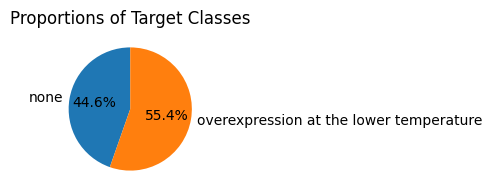

In [6]:
# plot proportions of target categories
fig, ax = plt.subplots(figsize=(2, 2)) 
data_class_props.plot(y='count', kind='pie', 
                          startangle=90,
                          title='Proportions of Target Classes',
                          legend=False,
                          labels=['none', 'overexpression at the lower temperature'],
                          ylabel='',
                          autopct='%1.1f%%',
                          ax=ax
                         )
ax.set_aspect('equal')
fig.savefig('figures/FRZI_target_class_proportions.svg', bbox_inches='tight')



## 3. Training/Test Split


Splitting the dataset into training and test sets allows for the estimation of how well the model will perform on unseen data. This estimation is crucial for assessing the model's applicability and avoiding overfitting.

In [7]:
# train-test-split of main data
features_train, features_test, target_train, target_test = train_test_split(data.drop('TSE', axis=1),
                                                                            data.loc[:, 'TSE'],
                                                                            test_size=0.1,
                                                                            random_state=42)

In [8]:
# train-test-split of baseline data
baseline_features_train, baseline_features_test, baseline_target_train, baseline_target_test = train_test_split(baseline.drop('TSE', axis=1),
                                                                                                               baseline.loc[:, 'TSE'],
                                                                                                               test_size=0.1,
                                                                                                               random_state=42)


In [9]:
set(target_test.index) == set(baseline_target_test.index) # same split in main and base data

True

## 3. Set up Cross-Chromosome Validation

Cross-chromosome validation involves dividing the data into two separate training and validation sets, ensuring that regions on the same chromosome are exclusively present in either the training or validation set. This measure prevents non-independent regions on the same chromosome from being present in both the training and test sets, which would otherwise violate the Independent and Identically Distributed (IID) assumption of most statistical models and potentially inflate performance (see *https://doi.org/10.1038/s41576-021-00434-9*).

In [10]:
# set up cross-chromosome validation
chroms = (features_train.index.to_series().str.extract('^([^_]+)'))
cross_chrom_cv = GroupKFold(n_splits = len(chroms[0].unique())) # number of splits corresponding to number of chroms (in this case: 5)
set(chroms[0])

{'2L', '2R', '3L', '3R', 'X'}

### Scorers used for evaluation of model performance:

The main scorers used to assess performance include two derived from the precision-recall curve: auPR (Area under the Precision-Recall curve) and AP (Average Precision), as well as the scorer auROC (Area under the Receiver Operating Characteristic curve). Employing these two types of scorers   allows to evaluate different aspects of model performance.

For instance, auROC can be high when auPR is low. The ROC curve is derived from the values of the true positive rate (tpr) and false positive rate (fpr) at different classifier thresholds:

$$tpr = \frac{tp}{tp + fn}$$
$$fpr = \frac{fp}{fp + tn}$$

Where tp = # true positives, fp = # false positives, tn = # true negatives, and fn = # false negatives.  Precision and recall are defined as:

$$\mathrm{precision} = \frac{tp}{tp + fp}$$
$$\mathrm{recall} = tpr = \frac{tp}{tp + fn}$$

For highly imbalanced problems in genomics, predicting the majority negative class is often much easier than predicting the minority positive class. Consequently, the abundance of true negatives tends to drive the false positive rate very low, thereby impacting the auROC. Unlike precision or recall, auPR does not measure true negatives, preventing inflation due to the easy predictability of the majority classes. This characteristic renders auPR a preferable choice over auROC for certain (though not all) genomics problems.

Even when dealing with balanced datasets, auPR remains a valuable metric, particularly if the costs associated with false positives and false negatives differ significantly or if precision and recall carry particular importance for the problem being addressed. The Precision-Recall Curve primarily assesses the performance of the positive class, offering insights into the model's capacity to accurately predict positive instances among all instances classified as positive (precision) and among all actual positive instances (recall).

Unfortunately, auPR is not available as a scorer for sklearn's cross-validation, thus the closely-related AP will be used in those instances. Instead of the area under the precision-recall curve as auPR, AP summarizes the shape of this curve, and is calculated a the weighted mean of precisions achieved at each threshold with increase in recall from the previous threshold used as weight:

$$
AP = \sum_{n}(R_n - R_{n-1})P_n
$$

where $P_n$ and $R_n$ are the precision and recall at the nth threshold.


## 4. Model and Feature Selection 

Tree-based models like Random Forests and Extreme Gradient Boosting (XGBoost) have become increasingly popular in the field of genetics and genomics due to their ability to handle complex, high-dimensional data and to model nonlinear relationships inherent in genetic data. These models also provide the advantage of elucidating interpretability and the importance of individual features, with offering metrics to underscore the significance of specific features.

### 4.1 Model and Feature Selection - Random Forest (RF)

#### Default model:

In [11]:
# default RF model
rf = Pipeline([('preprocessor', VarianceThreshold()), # removes zero-variance features.
               ('model', RandomForestClassifier(n_estimators= 100, class_weight='balanced', random_state=42))])


Default model performance with complete set of features (excluding zero-veariance features):

In [14]:
# cross-validate - RF model - all (non-zero-variance) features
rf_cv = cross_validate(rf,
                       features_train,
                       target_train,
                       groups = chroms,
                       cv = cross_chrom_cv,
                       scoring = ['average_precision', 'roc_auc'],
                       n_jobs=6)
print('Mean AP', rf_cv['test_average_precision'].mean())
print('Mean auROC', rf_cv['test_roc_auc'].mean())
rf_cv

Mean AP 0.6938763390445726
Mean auROC 0.6575326669239084


{'fit_time': array([4.08269882, 4.19523025, 4.36139226, 4.55219555, 4.69208908]),
 'score_time': array([0.25698471, 0.27291965, 0.23832798, 0.18489432, 0.13092804]),
 'test_average_precision': array([0.68877651, 0.68463591, 0.64612616, 0.75186377, 0.69797935]),
 'test_roc_auc': array([0.64405847, 0.63194264, 0.62511494, 0.69219512, 0.69435216])}

Compare performance to baseline model with mean gene activity (logCPM) as predictor:

In [15]:
# cross-validate - RF model - baseline
rf_baseline_cv = cross_validate(rf,
                                baseline_features_train,
                                baseline_target_train,
                                groups = chroms,
                                cv = cross_chrom_cv,
                                scoring = ['average_precision', 'roc_auc'],
                                n_jobs=6)
print('Mean auPR', rf_baseline_cv['test_average_precision'].mean())
print('Mean auROC', rf_baseline_cv['test_roc_auc'].mean())
rf_baseline_cv

Mean auPR 0.5983994842591237
Mean auROC 0.5392540409207662


{'fit_time': array([0.21322322, 0.38461614, 0.36053514, 0.39953256, 0.38945293]),
 'score_time': array([0.01316857, 0.02102065, 0.01711416, 0.01155305, 0.0160656 ]),
 'test_average_precision': array([0.61057856, 0.58603995, 0.61500559, 0.66150032, 0.518873  ]),
 'test_roc_auc': array([0.56233564, 0.47734262, 0.59841954, 0.54668293, 0.51148948])}

#### Feature selection using Recursive Feature Elimination (RFE):



In [41]:
# feature selection using recursive feature elimination (RFE) followed by cross-validation to assess model performance with selected features

rf_model = RandomForestClassifier(n_estimators= 100, class_weight='balanced', random_state=42)
scores = []
sel_features = {}

for n_features in [10, 20, 30, 40, 50, 60, 70, 80, 100, 200, 300]:

    # select features using RFE
    rf_rfe = RFE(rf_model,
                 n_features_to_select = n_features, 
                 step = 10)
    rf_rfe.fit(features_train, target_train)

    # get dataframe of selected features
    features_train_rfe = features_train[features_train.columns[rf_rfe.get_support()]]

    # cross-validate with selected features only
    rf_rfe = cross_validate(rf_model,
                            features_train_rfe,
                            target_train,
                            groups = chroms,
                            cv = cross_chrom_cv,
                            scoring = ['average_precision', 'roc_auc'],
                            n_jobs=6)
    
    # append cv scores to list
    scores.append([n_features,
                   rf_rfe['test_average_precision'].mean(),
                   rf_rfe['test_roc_auc'].mean(),
                   rf_rfe['test_average_precision'].std(),
                   rf_rfe['test_roc_auc'].std()
                   ])

    # add selected fearures to sel_features dictionary
    sel_features[n_features] = list(features_train_rfe.columns)


# create dataframe of results
rf_rfe_scores = pd.DataFrame(scores,
                             columns = ['n_selected_features',
                                        'AP_mean',
                                        'auROC_mean',
                                        'AP_sd',
                                        'auROC_sd',
                                        ])
rf_rfe_scores

,n_selected_features,AP_mean,auROC_mean,AP_sd,auROC_sd
0,10,0.735318,0.704243,0.015705,0.028196
1,20,0.764471,0.732980,0.016602,0.036441
2,30,0.759382,0.725643,0.024245,0.032516
3,40,0.750988,0.724298,0.026926,0.030847
4,50,0.750912,0.719483,0.020082,0.036107
5,60,0.751360,0.718091,0.020832,0.030010
6,70,0.747682,0.719039,0.029868,0.040968
7,80,0.745642,0.719082,0.039651,0.041724
8,100,0.741331,0.708149,0.032102,0.030033
9,200,0.723323,0.686562,0.038396,0.037890


In [42]:
# save rf_rfe_scores
rf_rfe_scores.to_csv('data/meta/FRZI_rf_rfe.csv', index=False)


In [12]:
# load rf_rfe_scores
rf_rfe_scores = pd.read_csv('data/meta/FRZI_rf_rfe.csv')
rf_rfe_scores

,n_selected_features,AP_mean,auROC_mean,AP_sd,auROC_sd
0,10,0.735318,0.704243,0.015705,0.028196
1,20,0.764471,0.732980,0.016602,0.036441
2,30,0.759382,0.725643,0.024245,0.032516
3,40,0.750988,0.724298,0.026926,0.030847
4,50,0.750912,0.719483,0.020082,0.036107
5,60,0.751360,0.718091,0.020832,0.030010
6,70,0.747682,0.719039,0.029868,0.040968
7,80,0.745642,0.719082,0.039651,0.041724
8,100,0.741331,0.708149,0.032102,0.030033
9,200,0.723323,0.686562,0.038396,0.037890


All selected features (up to 300 most relevant features) are TFBS motif scores.

In [53]:
# save sel_features
with open('data/meta/FRZI_rf_rfe_sel_features.txt', 'w') as file:
    json.dump(sel_features, file)  # encode dict into JSON


In [13]:
# load sel_features
with open('data/meta/FRZI_rf_rfe_sel_features.txt', 'r') as file:
    sel_features = json.load(file)
# convert the keys from strings to integers
sel_features = {int(key): value for key, value in sel_features.items()}

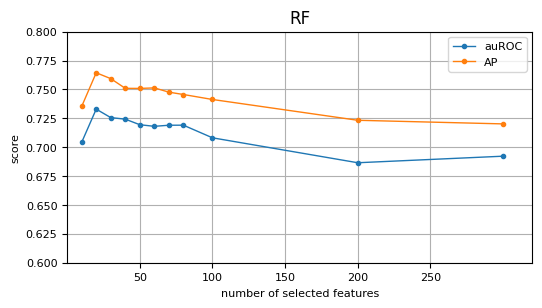

In [14]:
# plot AP and auROC vs number of selected features
plt.figure(figsize=(6, 3))
plt.plot(rf_rfe_scores.n_selected_features, rf_rfe_scores.auROC_mean, linewidth=1, marker='.', label='auROC')
plt.plot(rf_rfe_scores.n_selected_features, rf_rfe_scores.AP_mean, linewidth=1, marker='.', label='AP')
plt.grid()
plt.xlim(0, 320)
plt.ylim(0.6, 0.8)
plt.xticks(np.arange(50, 300, 50))
plt.xlabel('number of selected features', fontsize=8) 
plt.tick_params(axis='both', labelsize=8)
plt.ylabel('score', fontsize=8)
plt.legend(fontsize=8)
plt.title('RF')
plt.savefig('figures/FRZI_feature_sel_rfe_rf_scores.svg', bbox_inches='tight')

#### Optimize model - hyperparmeter tuning:

In [15]:
# number of estimators

scores_n_est = []

for n_est in [10, 20, 50, 80, 100, 200, 300, 400, 500, 600, 700, 800, 900, 1000, 1200, 1400, 1600, 1800, 2000]:
    rf_n_est = RandomForestClassifier(n_estimators= n_est, class_weight='balanced', random_state=42)
    rf_n_est_cv = cross_validate(rf_n_est,
                                 features_train[sel_features[20]],
                                 target_train,
                                 groups = chroms,
                                 cv = cross_chrom_cv,
                                 scoring = ['average_precision', 'roc_auc'],
                                 n_jobs=6)
    scores_n_est.append([n_est,
                         rf_n_est_cv['test_average_precision'].mean(),
                         rf_n_est_cv['test_roc_auc'].mean(),
                         rf_n_est_cv['test_average_precision'].std(),
                         rf_n_est_cv['test_roc_auc'].std()
                         ])

scores_n_est_df =pd.DataFrame(scores_n_est,
                              columns = ['n_estimators',
                                         'AP_mean',
                                         'auROC_mean',
                                         'AP_sd',
                                         'auROC_sd',
                                         ])
scores_n_est_df


,n_estimators,AP_mean,auROC_mean,AP_sd,auROC_sd
0,10,0.685932,0.663227,0.011360,0.059148
1,20,0.714833,0.688137,0.023616,0.061847
2,50,0.752973,0.724050,0.025781,0.042484
3,80,0.761838,0.728384,0.021204,0.035684
4,100,0.764471,0.732980,0.016602,0.036441
5,200,0.770261,0.735804,0.016182,0.033956
6,300,0.769448,0.733812,0.017406,0.033385
7,400,0.772970,0.735677,0.016165,0.031048
8,500,0.773326,0.737728,0.019546,0.032165
9,600,0.772836,0.738595,0.018268,0.031280


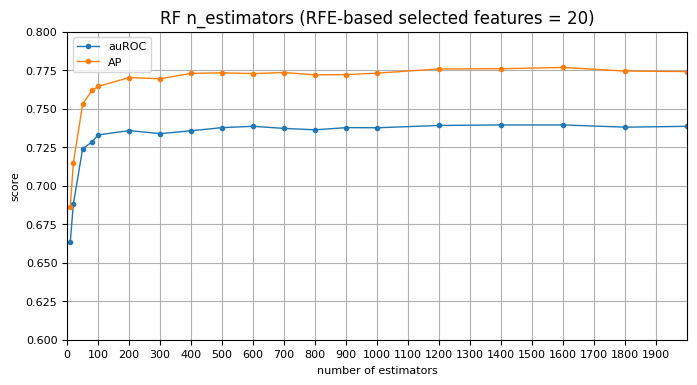

In [16]:
# plot AP and auROC vs number of selected features
plt.figure(figsize=(8, 4))
plt.plot(scores_n_est_df.n_estimators, scores_n_est_df.auROC_mean, linewidth=1, marker='.', label='auROC')
plt.plot(scores_n_est_df.n_estimators, scores_n_est_df.AP_mean, linewidth=1, marker='.', label='AP')
plt.xlim(0, 2000)
plt.ylim(0.6, 0.8)
plt.xticks(np.arange(0, 2000, 100))
plt.xlabel('number of estimators', fontsize=8) 
plt.tick_params(axis='both', labelsize=8)
plt.ylabel('score', fontsize=8)
plt.legend(fontsize=8)
plt.grid()
plt.title('RF n_estimators (RFE-based selected features = 20)')
plt.savefig('figures/FRZI_rf_nestimators_scores.svg', bbox_inches='tight')

Use Bayesian optimization with a search space of continuous hyperparameter values:

In [96]:
# define hyperparameter bounds (ie. dictionary with parameters names as keys and a tuple with minimum and maximum values)
rf_pbounds  = {
    'n_estimators': (500, 600),
    'criterion': (1, 2), # 1 for 'gini', 2 for 'entropy'
    'max_features': (1, 2), # 1 for 'sqrt', 2 for 'log2'
    'ccp_alpha': (0.00, 0.01), # 0 equals no pruning
    'max_samples': (0.5, 1), # lower values less prone to overfitting
    'max_depth': (3,15), # lower values less prone to overfitting
    'max_leaf_nodes': (10, 50), # lower values less prone to overfitting
    'min_samples_split': (2, 12),  # higher values less prone to overfitting
    'min_samples_leaf': (1, 10),  # higher values less prone to overfitting
    }

# categorical hyperparameter mapping
criterion_map = {1: 'gini', 2: 'entropy'}
max_features_map = {1: 'sqrt', 2: 'log2'}

In [97]:
# build objective function
def rf_hyper_param(**params):

    # convert parameters that need to be integers or categoricala
    params['max_depth'] = int(params['max_depth'])
    params['n_estimators'] = int(params['n_estimators'])
    params['max_leaf_nodes'] = int(params['max_leaf_nodes'])
    params['min_samples_split'] = int(params['min_samples_split'])
    params['min_samples_leaf'] = int(params['min_samples_leaf'])
    params['criterion'] = criterion_map[int(params['criterion'])]
    params['max_features'] = max_features_map[int(params['max_features'])]

    # model and cross-validation
    clf = RandomForestClassifier(**params, class_weight='balanced', random_state=42)
    cv = cross_validate(clf, 
                        features_train[sel_features[20]], 
                        target_train,
                        groups = chroms,
                        cv = cross_chrom_cv,
                        scoring = 'average_precision'
                        )
    
    return cv['test_score'].mean()

In [ ]:
# run optimization
optimizer = BayesianOptimization(f=rf_hyper_param,
                                 pbounds=rf_pbounds,
                                 random_state=42,
                                 )

optimizer.maximize(init_points=30, n_iter=120)

In [99]:
# get dataframe from xgb_optimizer output
rf_optimizer_df = pd.DataFrame([x['params'] for x in optimizer.res])
rf_optimizer_df['target'] = [x['target'] for x in optimizer.res]
display(rf_optimizer_df.sort_values(by='target', ascending=False).head(10))
display(rf_optimizer_df.sort_values(by='target', ascending=False).tail(10))

,ccp_alpha,criterion,max_depth,max_features,max_leaf_nodes,max_samples,min_samples_leaf,min_samples_split,n_estimators,target
108,0.000137,1.654568,12.045599,1.796191,46.151753,0.745024,6.071426,4.150915,539.408953,0.776044
65,0.000000,1.000000,12.409777,1.000000,47.113387,1.000000,5.447234,3.959755,538.370532,0.775567
101,0.000000,1.172806,12.874928,1.293007,47.112519,1.000000,5.764445,4.844445,538.599651,0.775567
36,0.000666,1.663228,12.323372,1.615702,45.553507,0.801721,6.533959,4.564936,538.414550,0.774524
38,0.000000,1.411708,13.678967,1.000000,43.653062,0.500000,6.863914,6.748417,540.119771,0.774178
63,0.000841,1.247980,13.474799,1.319275,47.961908,0.947505,5.181930,5.090083,538.664465,0.773959
64,0.000000,2.000000,13.380080,2.000000,46.982238,1.000000,6.255250,4.788109,538.254093,0.773254
124,0.000869,1.372444,14.122288,1.483819,42.987431,0.892042,6.224017,4.854616,543.426000,0.773201
93,0.001073,1.729172,13.764742,1.752336,44.248028,0.773085,6.642900,5.424031,542.059658,0.772868
113,0.001281,1.224177,11.734781,1.221286,44.873858,0.889770,5.954769,3.874684,539.892054,0.772867


,ccp_alpha,criterion,max_depth,max_features,max_leaf_nodes,max_samples,min_samples_leaf,min_samples_split,n_estimators,target
133,0.009844,1.671822,14.461862,1.557225,35.125443,0.701326,6.261073,11.669431,531.695516,0.758009
135,0.006753,1.374858,4.606620,1.539123,10.071138,0.603580,2.683175,10.376739,514.203507,0.757836
9,0.006233,1.330898,3.762700,1.310982,23.007333,0.864803,6.738017,10.872127,547.221493,0.757701
42,0.010000,1.000000,14.833862,2.000000,41.016427,1.000000,3.404253,5.156814,539.055541,0.757670
79,0.008986,1.077519,11.171498,1.455034,48.036253,0.679374,5.195979,4.213527,536.782893,0.757653
18,0.006335,1.535775,4.083477,1.835302,22.831203,0.593259,1.366976,7.908929,567.756436,0.757648
117,0.009519,1.947150,14.136457,1.146905,38.946260,0.731033,3.577241,6.031974,503.526880,0.757427
126,0.009764,1.433361,3.024755,1.146307,48.959726,0.564363,4.550052,9.409714,542.580791,0.756297
35,0.008887,1.416854,3.195383,1.082563,46.323257,0.780539,7.793164,11.787544,502.301600,0.755271
14,0.008180,1.860731,3.083426,1.510747,26.696440,0.611054,2.078788,5.376152,594.290970,0.754867


Round 2 of Bayesian optimization with refined ranges based on first round of hyperparaneter tuning:

In [101]:
# define hyperparameter bounds (ie. dictionary with parameters names as keys and a tuple with minimum and maximum values)
rf_pbounds2  = {
    'n_estimators': (540, 540),
    'criterion': (1, 2), # 1 for 'gini', 2 for 'entropy'
    'max_features': (1, 2), # 1 for 'sqrt', 2 for 'log2'
    'ccp_alpha': (0.00, 0.001), # 0 equals no pruning
    'max_samples': (0.5, 1), # lower values less prone to overfitting
    'max_depth': (12,14), # lower values less prone to overfitting
    'max_leaf_nodes': (40, 50), # lower values less prone to overfitting
    'min_samples_split': (3, 7),  # higher values less prone to overfitting
    'min_samples_leaf': (5, 7),  # higher values less prone to overfitting
    }

# categorical hyperparameter mapping
criterion_map = {1: 'gini', 2: 'entropy'}
max_features_map = {1: 'sqrt', 2: 'log2'}

In [ ]:
# run optimization
optimizer2 = BayesianOptimization(f=rf_hyper_param,
                                 pbounds=rf_pbounds2,
                                 random_state=42,
                                 )

optimizer2.maximize(init_points=30, n_iter=100)

In [103]:
# get dataframe from xgb_optimizer output
rf_optimizer2_df = pd.DataFrame([x['params'] for x in optimizer2.res])
rf_optimizer2_df['target'] = [x['target'] for x in optimizer2.res]
display(rf_optimizer2_df.sort_values(by='target', ascending=False).head(5))

,ccp_alpha,criterion,max_depth,max_features,max_leaf_nodes,max_samples,min_samples_leaf,min_samples_split,n_estimators,target
12,0.000229,1.076980,12.579503,1.161221,49.296977,0.904060,6.266808,6.485842,540.0,0.777043
96,0.000406,1.610166,13.767254,1.025941,44.502335,0.792453,5.280807,3.263910,540.0,0.776866
36,0.000362,1.268689,12.667481,1.265469,49.429376,0.954316,6.194471,6.613654,540.0,0.775917
108,0.000000,1.554700,13.487262,1.602554,47.675261,0.826856,6.083927,4.721428,540.0,0.775622
125,0.000888,1.871207,12.993531,1.711816,46.495273,0.916943,6.857541,5.217814,540.0,0.775384


In [104]:
# get best hyperparameter values
best_params = optimizer2.max['params']

# convert any float hyperparameters to integer if necessary
best_params['max_depth'] = int(best_params['max_depth'])
best_params['n_estimators'] = int(best_params['n_estimators'])
best_params['max_leaf_nodes'] = int(best_params['max_leaf_nodes'])
best_params['min_samples_split'] = int(best_params['min_samples_split'])
best_params['min_samples_leaf'] = int(best_params['min_samples_leaf'])
best_params['criterion'] = criterion_map[int(best_params['criterion'])]
best_params['max_features'] = max_features_map[int(best_params['max_features'])]

# print best parameters
print("Best hyperparameters:", best_params)

Best hyperparameters: {'ccp_alpha': 0.00022879816549162247, 'criterion': 'gini', 'max_depth': 12, 'max_features': 'sqrt', 'max_leaf_nodes': 49, 'max_samples': 0.9040601897822085, 'min_samples_leaf': 6, 'min_samples_split': 6, 'n_estimators': 540}


In [105]:
# optimized RF model
rf_opt = RandomForestClassifier(**best_params, class_weight='balanced', random_state=42)
rf_opt

RandomForestClassifier(ccp_alpha=0.00022879816549162247,
                       class_weight='balanced', max_depth=12, max_leaf_nodes=49,
                       max_samples=0.9040601897822085, min_samples_leaf=6,
                       min_samples_split=6, n_estimators=540, random_state=42)

In [106]:
# save untrained, optimized RF model
joblib.dump(RandomForestClassifier(**best_params, class_weight='balanced', random_state=42), 'models/rf_opt_untrained.joblib')

['models/rf_opt_untrained.joblib']

Optimized model performance:

In [107]:
# cross-validate optimized model
rf_opt_cv = cross_validate(rf_opt,
                           features_train[sel_features[20]],
                           target_train,
                           groups = chroms,
                           cv = cross_chrom_cv,
                           scoring = ['average_precision', 'roc_auc'])
print('Mean AP', rf_opt_cv['test_average_precision'].mean())
print('Mean auROC', rf_opt_cv['test_roc_auc'].mean())
rf_opt_cv

Mean AP 0.7770426306227651
Mean auROC 0.7442479578293426


{'fit_time': array([2.02655363, 2.11217213, 2.60240555, 2.68768764, 2.68310809]),
 'score_time': array([0.05178785, 0.0730474 , 0.05541801, 0.1503408 , 0.0583384 ]),
 'test_average_precision': array([0.80144946, 0.78495122, 0.74239826, 0.78784578, 0.76856844]),
 'test_roc_auc': array([0.76729252, 0.7063989 , 0.71925287, 0.73482927, 0.79346622])}

Compare performance to baseline model with mean gene activity (logCPM) as predictor:

In [108]:
# cross-validate optimized model - baseline
rf_opt_baseline_cv = cross_validate(rf_opt,
                                    baseline_features_train,
                                    baseline_target_train,
                                    groups = chroms,
                                    cv = cross_chrom_cv,
                                    scoring = ['average_precision', 'roc_auc'])
print('Mean AP', rf_opt_baseline_cv['test_average_precision'].mean())
print('Mean auROC', rf_opt_baseline_cv['test_roc_auc'].mean())
rf_opt_baseline_cv


Mean AP 0.6067090919924575
Mean auROC 0.5421711940892682


{'fit_time': array([1.27380919, 1.13890219, 1.02076674, 0.9538734 , 0.94098353]),
 'score_time': array([0.05085301, 0.04594207, 0.03429723, 0.03411174, 0.03187418]),
 'test_average_precision': array([0.59559457, 0.60842372, 0.6058985 , 0.66170489, 0.56192377]),
 'test_roc_auc': array([0.55881903, 0.49025529, 0.53488506, 0.55512195, 0.57177464])}

Learning curve to assess if model is overfitting or underfitting:

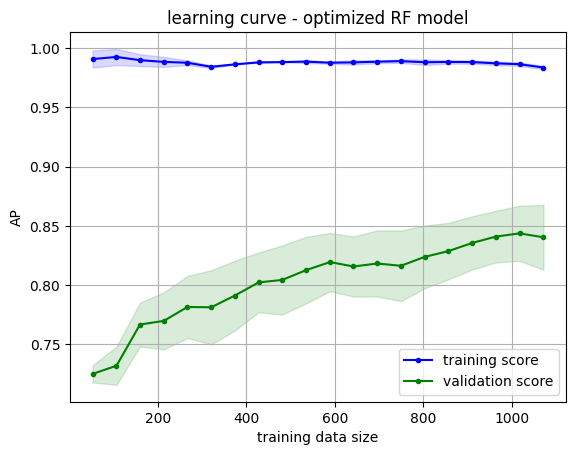

In [19]:
# learning curve to assess potential overfitting/underfitting

# Define training sizes and use learning_curve function
train_sizes, train_scores, validation_scores = learning_curve(rf_opt,
                                                              features_train[sel_features[20]],
                                                              target_train,
                                                              train_sizes=np.linspace(0.05, 1.0, 20), # training sizes (10 points from 10% to 100% of the training data)
                                                              cv=5,
                                                              scoring = 'average_precision',
                                                              n_jobs=6)


# calculate mean and standard deviation for training set scores
train_mean = np.mean(train_scores, axis=1)
train_std = np.std(train_scores, axis=1)

# calculate mean and standard deviation for validation set scores
validation_mean = np.mean(validation_scores, axis=1)
validation_std = np.std(validation_scores, axis=1)

# plot the learning curves
plt.plot(train_sizes, train_mean, label='training score', color='blue', marker='.')
plt.fill_between(train_sizes, train_mean - train_std, train_mean + train_std, color='blue', alpha=0.15)
plt.plot(train_sizes, validation_mean, label='validation score', color='green', marker='.')
plt.fill_between(train_sizes, validation_mean - validation_std, validation_mean + validation_std, color='green', alpha=0.15)
plt.title('learning curve - optimized RF model')
plt.xlabel('training data size')
plt.ylabel('AP')
plt.legend()
plt.grid()
plt.savefig('figures/FRZI_rf_opt_learning_curve.svg', bbox_inches='tight')


Training score remains consistnetly close to 1 regardless of training size. This indicates that model is able to learn the training data well. The gap between the training and validation scores narrows as more training data is added, which typically suggests that overfitting is less of a concern. The validation score seems to be plateauing towards the larger training sizes suggesting that simply adding more data might not result in significant performance gains beyond this point. It could mean that the model has learned as much as it can from the data provided and additional samples are not providing new information to improve the model's generalization. Additionally, there is a noticeable gap between the training and validation scores. Such a gap typically signifies some level of overfitting—the model is learning the training data very well but not performing quite as well on unseen data.

In [110]:
# save trained, optimized model
rf_opt.fit(features_train[sel_features[20]], target_train)
joblib.dump(rf_opt, 'models/rf_opt_trained.joblib')

['models/rf_opt_trained.joblib']

In [18]:
# load optimized model
rf_opt = joblib.load( 'models/rf_opt_trained.joblib')

#### Test model on test data:

In [112]:
# test model on test data
rf_opt.fit(features_train[sel_features[20]], target_train)
target_test_pred = rf_opt.predict(features_test[sel_features[20]])
target_test_pred_probs = rf_opt.predict_proba(features_test[sel_features[20]])[:, 1]

In [113]:
# AP
print('AP:', average_precision_score(target_test, target_test_pred_probs))

# auPR
precision, recall, _ = precision_recall_curve(target_test, target_test_pred_probs)
print('auPR:', auc(recall, precision))

# auROC
print('auROC:', roc_auc_score(target_test, target_test_pred))

AP: 0.7565179596477791
auPR: 0.7483140082951699
auROC: 0.6974585436193224


In [114]:
# classification report
print(classification_report(target_test, target_test_pred))

              precision    recall  f1-score   support

           0       0.70      0.67      0.69        73
           1       0.70      0.72      0.71        76

    accuracy                           0.70       149
   macro avg       0.70      0.70      0.70       149
weighted avg       0.70      0.70      0.70       149



Compare to baseline predictor:

In [115]:
# optimized RF model - baseline
rf_opt.fit(baseline_features_test, baseline_target_test)
baseline_target_test_pred = rf_opt.predict(baseline_features_test)
baseline_target_test_pred_probs = rf_opt.predict_proba(baseline_features_test)[:, 1]

# AP
print('AP:', average_precision_score(baseline_target_test, baseline_target_test_pred_probs))

# auPR
precision, recall, _ = precision_recall_curve(baseline_target_test, baseline_target_test_pred_probs)
print('auPR:', auc(recall, precision))

# auROC
print('auROC:', roc_auc_score(baseline_target_test, baseline_target_test_pred))



AP: 0.7887773278896313
auPR: 0.786941916477661
auROC: 0.6656452775775055


In [116]:
# classification report
print(classification_report(baseline_target_test, baseline_target_test_pred))

              precision    recall  f1-score   support

           0       0.64      0.73      0.68        73
           1       0.70      0.61      0.65        76

    accuracy                           0.66       149
   macro avg       0.67      0.67      0.66       149
weighted avg       0.67      0.66      0.66       149



Performance of the trained and optimized model on the test data is similar to a baseline predictor and the baseline yields higher recall for the negative class, leading to a higher area under the Precision-Recall curve (auPR) and Average Precision (AP). Thus, the Random Forest algorithm might not be the best choice for your specific dataset.

### 4.2 Model and Feature Selection - XGBoost (XGB)

#### Default model:

In [20]:
# default xgb model
xgb_model = XGBClassifier(scale_pos_weight=0.806, random_state=42)

Feature selection based on the RFE-selected features from the RF model (see above):

In [ ]:
scores_xgb = []
for n_features in [10, 20, 30, 40, 50, 60, 70, 80, 100, 200, 300]:

    xgb_cv = cross_validate(xgb_model,
                            features_train[sel_features[n_features]],
                            target_train,
                            groups = chroms,
                            cv = cross_chrom_cv,
                            scoring = ['average_precision', 'roc_auc'],
                            n_jobs=6)

    # append cv scores to list
    scores_xgb.append([n_features,
                      xgb_cv['test_average_precision'].mean(),
                      xgb_cv['test_roc_auc'].mean(),
                      xgb_cv['test_average_precision'].std(),
                      xgb_cv['test_roc_auc'].std()
                      ])

# create dataframe of results
xgb_rfrfe_scores = pd.DataFrame(scores_xgb,
                                 columns = ['n_selected_features',
                                            'AP_mean',
                                            'auROC_mean',
                                            'AP_sd',
                                            'auROC_sd'
                                            ])
xgb_rfrfe_scores

In [137]:
# save xgb_rfrfe_scores
xgb_rfrfe_scores.to_csv('data/meta/FRZI_xgb_rfrfe.csv', index=False)

In [21]:
# load xgb_rfrfe_scores
xgb_rfrfe_scores = pd.read_csv('data/meta/FRZI_xgb_rfrfe.csv')
xgb_rfrfe_scores

,n_selected_features,AP_mean,auROC_mean,AP_sd,auROC_sd
0,10,0.693890,0.662077,0.035677,0.033203
1,20,0.757675,0.727603,0.034171,0.028176
2,30,0.769956,0.728485,0.014309,0.038519
3,40,0.747896,0.722648,0.015726,0.032479
4,50,0.765264,0.720338,0.017076,0.033009
5,60,0.767834,0.723969,0.020977,0.038920
6,70,0.776794,0.729951,0.017979,0.032534
7,80,0.744920,0.708543,0.027876,0.019532
8,100,0.751107,0.709723,0.027201,0.017964
9,200,0.735187,0.669858,0.019192,0.024890


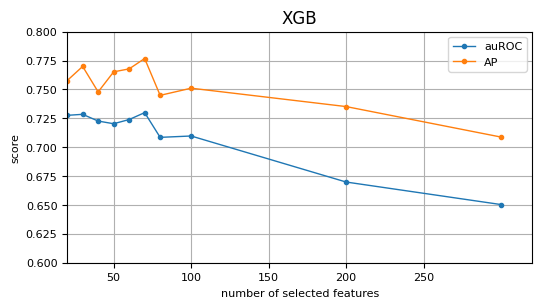

In [22]:
# plot AP and auROC vs number of selected features
plt.figure(figsize=(6, 3))
plt.plot(xgb_rfrfe_scores.n_selected_features, xgb_rfrfe_scores.auROC_mean, linewidth=1, marker='.', label='auROC')
plt.plot(xgb_rfrfe_scores.n_selected_features, xgb_rfrfe_scores.AP_mean, linewidth=1, marker='.', label='AP')
plt.grid()
plt.xlim(20, 320)
plt.ylim(0.6, 0.8)
plt.xticks(np.arange(50, 300, 50))
plt.xlabel('number of selected features', fontsize=8) 
plt.tick_params(axis='both', labelsize=8)
plt.ylabel('score', fontsize=8)
plt.legend(fontsize=8)
plt.title('XGB')
plt.savefig('figures/FRZI_xgb_rfrfe_scores.svg', bbox_inches='tight')


The default XGBoost model achieves its peak performance using the top 70 features identified through Recursive Feature Elimination (RFE).

In [254]:
# save selected features 
pd.DataFrame(sel_features[70], columns=['selected_features']).to_csv('data/meta/xgb_selected_features.csv', index=False)

Default model performance with RFE-selected features (n=70):

In [142]:
# cross-validate - RF model - all (non-zero-variance) features
xgb_cv = cross_validate(xgb_model,
                       features_train[sel_features[70]],
                       target_train,
                       groups = chroms,
                       cv = cross_chrom_cv,
                       scoring = ['average_precision', 'roc_auc'],
                       n_jobs=6)
print('Mean AP', xgb_cv['test_average_precision'].mean())
print('Mean auROC', xgb_cv['test_roc_auc'].mean())
xgb_cv

Mean AP 0.7767944901742414
Mean auROC 0.7299511337629147


{'fit_time': array([1.12353587, 1.15001369, 1.22717381, 1.21338892, 1.27838898]),
 'score_time': array([0.02741528, 0.01936102, 0.01540923, 0.0161531 , 0.01794028]),
 'test_average_precision': array([0.76250442, 0.76813609, 0.76097165, 0.80912476, 0.78323554]),
 'test_roc_auc': array([0.72463458, 0.70236022, 0.71436782, 0.71492683, 0.79346622])}

Compare performance to baseline model with mean gene activity (logCPM) as predictor:

In [143]:
# cross-validate - RF model - all (non-zero-variance) features
xgb_cv = cross_validate(xgb_model,
                       baseline_features_train,
                       baseline_target_train,
                       groups = chroms,
                       cv = cross_chrom_cv,
                       scoring = ['average_precision', 'roc_auc'],
                       n_jobs=6)
print('Mean AP', xgb_cv['test_average_precision'].mean())
print('Mean auROC', xgb_cv['test_roc_auc'].mean())
xgb_cv

Mean AP 0.5976539738271915
Mean auROC 0.5198155519652127


{'fit_time': array([0.07396579, 0.07881665, 0.07989311, 0.07407475, 0.07674456]),
 'score_time': array([0.0083437 , 0.00648808, 0.00893402, 0.00559807, 0.00500536]),
 'test_average_precision': array([0.59288159, 0.60660066, 0.57247278, 0.6322668 , 0.58404804]),
 'test_roc_auc': array([0.54123601, 0.48553114, 0.49163793, 0.51692683, 0.56374585])}

#### Optimize model - hyperparmeter tuning:

In [23]:
# number of estimators

scores_n_est = []

for n_est in [10, 20, 50, 80, 100, 200, 400, 300, 500, 600, 700, 800, 900, 1000, 1200, 1400, 1600, 1800, 2000]:
    rf_n_est = XGBClassifier(n_estimators= n_est, scale_pos_weight=0.806, random_state=42)
    rf_n_est_cv = cross_validate(rf_n_est,
                                 features_train[sel_features[70]],
                                 target_train,
                                 groups = chroms,
                                 cv = cross_chrom_cv,
                                 scoring = ['average_precision', 'roc_auc'],
                                 n_jobs=6)
    scores_n_est.append([n_est,
                         rf_n_est_cv['test_average_precision'].mean(),
                         rf_n_est_cv['test_roc_auc'].mean(),
                         rf_n_est_cv['test_average_precision'].std(),
                         rf_n_est_cv['test_roc_auc'].std()
                         ])

scores_n_est_df =pd.DataFrame(scores_n_est,
                              columns = ['n_estimators',
                                         'AP_mean',
                                         'auROC_mean',
                                         'AP_sd',
                                         'auROC_sd',
                                         ])
scores_n_est_df


,n_estimators,AP_mean,auROC_mean,AP_sd,auROC_sd
0,10,0.738972,0.685795,0.026107,0.024749
1,20,0.747678,0.705010,0.036441,0.028643
2,50,0.768980,0.724758,0.014415,0.036231
3,80,0.773514,0.726601,0.018787,0.032647
4,100,0.776794,0.729951,0.017979,0.032534
5,200,0.780334,0.733987,0.018234,0.026003
6,400,0.783587,0.737099,0.021449,0.027443
7,300,0.781760,0.735174,0.019394,0.026957
8,500,0.784926,0.738440,0.022412,0.027545
9,600,0.784550,0.738399,0.023133,0.028270


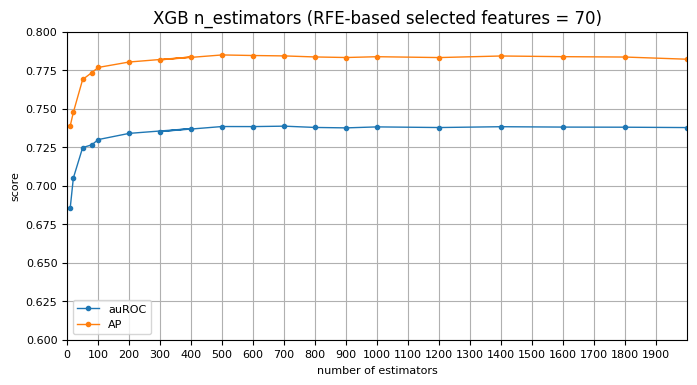

In [24]:
# plot AP and auROC vs number of selected features
plt.figure(figsize=(8, 4))
plt.plot(scores_n_est_df.n_estimators, scores_n_est_df.auROC_mean, linewidth=1, marker='.', label='auROC')
plt.plot(scores_n_est_df.n_estimators, scores_n_est_df.AP_mean, linewidth=1, marker='.', label='AP')
plt.xlim(0, 2000)
plt.ylim(0.6, 0.8)
plt.xticks(np.arange(0, 2000, 100))
plt.xlabel('number of estimators', fontsize=8) 
plt.tick_params(axis='both', labelsize=8)
plt.ylabel('score', fontsize=8)
plt.legend(fontsize=8)
plt.grid()
plt.title('XGB n_estimators (RFE-based selected features = 70)')
plt.savefig('figures/FRZI_xgb_nestimators_scores.svg', bbox_inches='tight')

In [25]:
# learning rate

scores_xgb_lrate = []

for lrate in [0.001, 0.005, 0.01, 0.02, 0.03, 0.04, 0.05, 0.06, 0.07, 0.08, 0.09, 0.1]:
    xgb_lrate = XGBClassifier(learning_rate=lrate, n_estimators=500, scale_pos_weight=0.806, random_state=42)
    xgb_lrate_cv = cross_validate(xgb_lrate,
                                  features_train[sel_features[70]],
                                  target_train,
                                  groups = chroms,
                                  cv = cross_chrom_cv,
                                  scoring = ['average_precision', 'roc_auc'],
                                  n_jobs=6)
    scores_xgb_lrate.append([lrate,
                             xgb_lrate_cv['test_average_precision'].mean(),
                             xgb_lrate_cv['test_roc_auc'].mean(),
                             xgb_lrate_cv['test_average_precision'].std(),
                             xgb_lrate_cv['test_roc_auc'].std()
                             ])

scores_xgb_lrate_df = pd.DataFrame(scores_xgb_lrate,
                                   columns = ['learning_rate',
                                              'AP_mean',
                                              'auROC_mean',
                                              'AP_sd',
                                              'auROC_sd',
                                              ])
scores_xgb_lrate_df


,learning_rate,AP_mean,auROC_mean,AP_sd,auROC_sd
0,0.001,0.717503,0.670208,0.034592,0.013981
1,0.005,0.739271,0.695739,0.035760,0.021747
2,0.010,0.746630,0.707566,0.033473,0.019781
3,0.020,0.756932,0.715120,0.020858,0.022501
4,0.030,0.766862,0.727910,0.019942,0.017086
5,0.040,0.762462,0.720990,0.019041,0.014946
6,0.050,0.769493,0.727261,0.021379,0.019084
7,0.060,0.767515,0.727401,0.014293,0.018390
8,0.070,0.765054,0.726871,0.014495,0.018113
9,0.080,0.770516,0.730601,0.018921,0.016036


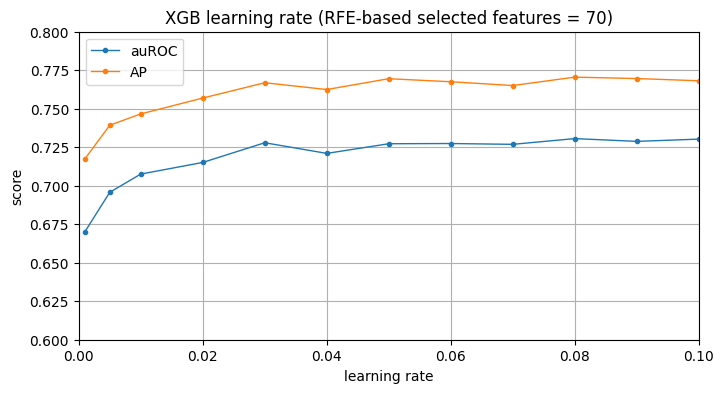

In [26]:
# plot AP and auROC vs learning rate
plt.figure(figsize=(8, 4))
plt.plot(scores_xgb_lrate_df.learning_rate, scores_xgb_lrate_df.auROC_mean, linewidth=1, marker='.', label='auROC')
plt.plot(scores_xgb_lrate_df.learning_rate, scores_xgb_lrate_df.AP_mean, linewidth=1, marker='.', label='AP')
plt.xlim(0, 0.1)
plt.ylim(0.6, 0.8)
plt.xlabel('learning rate', fontsize=10) 
plt.tick_params(axis='both', labelsize=10)
plt.ylabel('score', fontsize=10)
plt.legend(fontsize=10)
plt.grid()
plt.title('XGB learning rate (RFE-based selected features = 70)')
plt.savefig('figures/FRZI_xgb_learningrate_scores.svg', bbox_inches='tight')

Use Bayesian optimization with a search space of continuous hyperparameter values:

In [210]:
# define hyperparameter bounds (ie. dictionary with parameters names as keys and a tuple with minimum and maximum values) (round1)
xgb_pbounds  = {
    'n_estimators': (500, 500), 
    'learning_rate': (0.05, 0.08), # step size shrinkage of weights to avoid overfitting, ie. how much weight are updated, higher values more prone to overfitting
    'gamma': (0, 0.5), # minimum loss reduction required for further split, lower values more prone to overfitting
    'max_depth': (3, 10), # lower values less prone to overfitting
    'min_child_weight': (1, 10), # minimum sum of instance weight (hessian) needed in a child to further split, higher values less prone to overfitting
    'subsample': (0.5, 1), # fraction of samples considered per tree
    'colsample_bytree': (0.5, 1), # fractions of features considered per tree
    'reg_lambda': (0.01, 10),  # L2 regularization () - higher values (ie. more regularized) less prone to overfitting
    }

In [211]:
# build objective function
def xgb_hyper_param(**params):

    # convert parameters that need to be integers 
    params['max_depth'] = int(params['max_depth'])
    params['n_estimators'] = int(params['n_estimators'])

    # model and cross-validation
    clf = XGBClassifier(**params, scale_pos_weight=0.806, random_state=42)
    cv = cross_validate(clf, 
                        features_train[sel_features[70]],
                        target_train,
                        groups = chroms,
                        cv = cross_chrom_cv,
                        scoring = 'average_precision',
                        n_jobs=6
                        )
    
    return cv['test_score'].mean()

In [ ]:
# run optimization
optimizer = BayesianOptimization(f=xgb_hyper_param,
                                 pbounds=xgb_pbounds,
                                 random_state=42,
                                 )

optimizer.maximize(init_points=50, n_iter=150)

In [213]:
# get dataframe from xgb_optimizer output
xgb_optimizer_df = pd.DataFrame([x['params'] for x in optimizer.res])
xgb_optimizer_df['target'] = [x['target'] for x in optimizer.res]
display(xgb_optimizer_df.sort_values(by='target', ascending=False).head(10))
display(xgb_optimizer_df.sort_values(by='target', ascending=False).tail(10))

,colsample_bytree,gamma,learning_rate,max_depth,min_child_weight,n_estimators,reg_lambda,subsample,target
132,0.870708,0.295175,0.056071,6.908610,3.078125,500.0,7.142098,0.907614,0.783736
148,0.937143,0.434037,0.070494,7.247510,1.129539,500.0,1.502405,0.501264,0.783374
141,0.671419,0.091575,0.078267,6.575784,7.330175,500.0,1.007116,0.832341,0.781769
73,0.594792,0.060586,0.072201,7.174832,5.804486,500.0,2.834729,0.596693,0.781338
49,0.686009,0.388206,0.060224,9.515301,8.725715,500.0,7.511202,0.877271,0.780773
137,0.598341,0.010134,0.053749,7.180192,1.647401,500.0,9.017062,0.961351,0.780683
64,0.845951,0.102454,0.071812,9.055689,1.632015,500.0,1.888954,0.799959,0.780446
33,0.938687,0.370384,0.070910,7.917389,4.235420,500.0,8.095518,0.905057,0.780145
126,0.626113,0.128155,0.060550,6.280263,9.521786,500.0,9.013749,0.907933,0.779548
165,0.767905,0.269913,0.077426,7.520147,7.271510,500.0,8.526718,0.850334,0.779340


,colsample_bytree,gamma,learning_rate,max_depth,min_child_weight,n_estimators,reg_lambda,subsample,target
56,0.836089,0.387800,0.054875,3.903806,4.104696,500.0,1.199900,0.975161,0.762535
153,0.674001,0.421185,0.063057,4.716160,4.421939,500.0,3.670750,0.708064,0.762501
187,0.602677,0.020339,0.076833,8.773231,8.248919,500.0,2.008269,0.673341,0.762227
115,0.993837,0.402583,0.076013,3.733612,7.721983,500.0,4.520837,0.551002,0.761600
156,0.636571,0.498523,0.050829,9.578335,1.345007,500.0,0.043070,0.705665,0.761497
122,0.880446,0.482236,0.075753,8.349324,3.639585,500.0,5.873413,0.710274,0.761330
160,0.703132,0.469808,0.056299,9.952739,8.560217,500.0,6.788919,0.565571,0.760513
28,0.632601,0.121995,0.079190,5.751684,9.028419,500.0,7.950165,0.751319,0.760201
79,0.867531,0.127605,0.070071,4.905933,9.957216,500.0,9.978669,0.549073,0.759703
157,0.602780,0.038224,0.072851,5.814182,9.086798,500.0,1.179129,0.516992,0.758385


In [241]:
# get best hyperparameter values
xgb_best_params = optimizer.max['params']

# convert any float hyperparameters to integer if necessary
xgb_best_params['max_depth'] = int(xgb_best_params['max_depth'])
xgb_best_params['n_estimators'] = int(xgb_best_params['n_estimators'])


#  print best parameters
print("Best hyperparameters - xgb_optimizer:", xgb_best_params)

Best hyperparameters - xgb_optimizer: {'colsample_bytree': 0.8707077438668258, 'gamma': 0.29517518397558595, 'learning_rate': 0.05607053766206377, 'max_depth': 6, 'min_child_weight': 3.0781249862572944, 'n_estimators': 500, 'reg_lambda': 7.142097535183238, 'subsample': 0.9076136351359245}


In [242]:
# optimized model
xgb_opt = XGBClassifier(**xgb_best_params, scale_pos_weight=0.806, random_state=42)
xgb_opt

XGBClassifier(base_score=None, booster=None, callbacks=None,
              colsample_bylevel=None, colsample_bynode=None,
              colsample_bytree=0.8707077438668258, device=None,
              early_stopping_rounds=None, enable_categorical=False,
              eval_metric=None, feature_types=None, gamma=0.29517518397558595,
              grow_policy=None, importance_type=None,
              interaction_constraints=None, learning_rate=0.05607053766206377,
              max_bin=None, max_cat_threshold=None, max_cat_to_onehot=None,
              max_delta_step=None, max_depth=6, max_leaves=None,
              min_child_weight=3.0781249862572944, missing=nan,
              monotone_constraints=None, multi_strategy=None, n_estimators=500,
              n_jobs=None, num_parallel_tree=None, random_state=42, ...)

In [243]:
# save untrained, optimized XGB model
joblib.dump(XGBClassifier(**xgb_best_params, scale_pos_weight=0.806, random_state=42), 'models/xgb_opt_untrained.joblib')

['models/xgb_opt_untrained.joblib']

Optimized model performance:

In [244]:
xgb_opt_cv = cross_validate(xgb_opt,
                            features_train[sel_features[70]],
                            target_train,
                            groups = chroms,
                            cv = cross_chrom_cv,
                            scoring = ['average_precision', 'roc_auc'])
print('Mean AP', xgb_opt_cv['test_average_precision'].mean())
print('Mean auROC', xgb_opt_cv['test_roc_auc'].mean())
xgb_opt_cv

Mean AP 0.7837356831871983
Mean auROC 0.739002672340575


{'fit_time': array([3.29849935, 2.81300116, 3.12547755, 3.24745059, 2.21694875]),
 'score_time': array([0.02143931, 0.03722239, 0.03143954, 0.01899314, 0.02260375]),
 'test_average_precision': array([0.75246297, 0.78088949, 0.78270382, 0.82443662, 0.77818551]),
 'test_roc_auc': array([0.7196196 , 0.72322057, 0.74471264, 0.74887805, 0.7585825 ])}

Compare performance to baseline model with mean gene activity (logCPM) as predictor:

In [253]:
# cross-validate optimized model - baseline
xgb_opt_baseline_cv = cross_validate(xgb_opt,
                                     baseline_features_train,
                                     baseline_target_train,
                                     groups = chroms,
                                     cv = cross_chrom_cv,
                                     scoring = ['average_precision', 'roc_auc'])
print('Mean AP', xgb_opt_baseline_cv['test_average_precision'].mean())
print('Mean auROC', xgb_opt_baseline_cv['test_roc_auc'].mean())
xgb_opt_baseline_cv


Mean AP 0.5996857040017012
Mean auROC 0.5366547809059921


{'fit_time': array([0.92087483, 1.28470826, 0.68666553, 0.21289921, 0.19909191]),
 'score_time': array([0.02409577, 0.0617969 , 0.006181  , 0.00757957, 0.00553989]),
 'test_average_precision': array([0.59273451, 0.59958718, 0.57155399, 0.63896212, 0.59559072]),
 'test_roc_auc': array([0.5635588 , 0.48477157, 0.51221264, 0.5164878 , 0.60624308])}

Learning curve to assess if model is overfitting or underfitting:

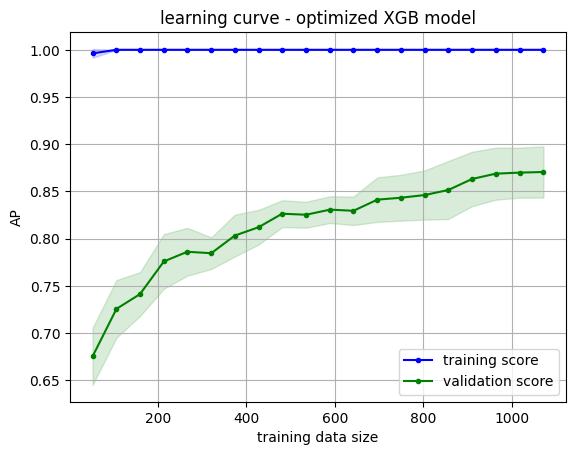

In [29]:
# learning curve to assess potential overfitting

# Define training sizes and use learning_curve function
train_sizes, train_scores, validation_scores = learning_curve(xgb_opt,
                                                              features_train[sel_features[70]],
                                                              target_train,
                                                              train_sizes=np.linspace(0.05, 1.0, 20), # training sizes (10 points from 10% to 100% of the training data)
                                                              cv=5,
                                                              scoring = 'average_precision',
                                                              n_jobs=6)


# calculate mean and standard deviation for training set scores
train_mean = np.mean(train_scores, axis=1)
train_std = np.std(train_scores, axis=1)

# calculate mean and standard deviation for validation set scores
validation_mean = np.mean(validation_scores, axis=1)
validation_std = np.std(validation_scores, axis=1)

# plot the learning curves
plt.plot(train_sizes, train_mean, label='training score', color='blue', marker='.')
plt.fill_between(train_sizes, train_mean - train_std, train_mean + train_std, color='blue', alpha=0.15)
plt.plot(train_sizes, validation_mean, label='validation score', color='green', marker='.')
plt.fill_between(train_sizes, validation_mean - validation_std, validation_mean + validation_std, color='green', alpha=0.15)
plt.title('learning curve - optimized XGB model')
plt.xlabel('training data size')
plt.ylabel('AP')
plt.legend()
plt.grid()
plt.savefig('figures/FRZI_xgb_opt_learning_curve.svg', bbox_inches='tight')

The model achieves a high Average Precision (AP) on the training set, which remains consistent across different training set sizes.  The validation score is improving as the training data size increases, which suggests the model benefits from more data and is learning generalizable patterns. As more training data is used, the validation score is approaching the training score. This convergence is a good sign as it implies that with more data, the model could become less overfitted and generalize better. The gap between the training and validation scores is present but not as wide as it might be in cases of critical overfitting. The gap also seems to be closing with the increase in training data size, which is a positive indicator of the model's ability to generalize. 

In [246]:
# save trained, optimized model
xgb_opt.fit(features_train[sel_features[70]], target_train)
joblib.dump(xgb_opt, 'models/xgb_opt_trained.joblib')

['models/xgb_opt_trained.joblib']

In [27]:
# load trained, optimized model
xgb_opt = joblib.load( 'models/xgb_opt_trained.joblib')

#### Test model on test data:

In [248]:
# test model on test data
xgb_opt.fit(features_train[sel_features[70]], target_train)
target_test_pred = xgb_opt.predict(features_test[sel_features[70]])
target_test_pred_probs = xgb_opt.predict_proba(features_test[sel_features[70]])[:, 1]

In [249]:
# AP
print('AP:', average_precision_score(target_test, target_test_pred_probs))

# auPR
precision, recall, _ = precision_recall_curve(target_test, target_test_pred_probs)
print('auPR:', auc(recall, precision))

# auROC
print('auROC:', roc_auc_score(target_test, target_test_pred))

AP: 0.9098890202124967
auPR: 0.9089224260905083
auROC: 0.8712148521989906


In [250]:
# classification report
print(classification_report(target_test, target_test_pred))

              precision    recall  f1-score   support

           0       0.92      0.81      0.86        73
           1       0.84      0.93      0.88        76

    accuracy                           0.87       149
   macro avg       0.88      0.87      0.87       149
weighted avg       0.88      0.87      0.87       149



Compare to baseline predictor:

In [251]:
# optimized RF model - baseline
xgb_opt.fit(baseline_features_test, baseline_target_test)
baseline_target_test_pred = xgb_opt.predict(baseline_features_test)
baseline_target_test_pred_probs = xgb_opt.predict_proba(baseline_features_test)[:, 1]

# AP
print('AP:', average_precision_score(baseline_target_test, baseline_target_test_pred_probs))

# auPR
precision, recall, _ = precision_recall_curve(baseline_target_test, baseline_target_test_pred_probs)
print('auPR:', auc(recall, precision))

# auROC
print('auROC:', roc_auc_score(baseline_target_test, baseline_target_test_pred))

AP: 0.804429311772023
auPR: 0.8072745480447164
auROC: 0.6820475847152127


The performance of the baseline predictor is lower than that of the optimized model using the selected feature set. Again, however,  the baseline predictor achieved a relatively strong performance on the test set. This performance may be specific to the test set, as validation sets in cross-validation using the baseline predictor demonstrated only a modest improvement over random classification (0.5).








 ---
###### The versions of the software used in this notebook were as follows:

###### bayesianoptimization: 1.4.3 - joblib: 1.3.2 - matplotlib: 3.8.3 - numpy: 1.26.4 - pandas: 2.2.0 - python: 3.9.16 - scikit-learn: 1.4.1.post1 - seaborn: 0.13.2 - xgboost: 2.0.3


